In [181]:
import random
import math
import os

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [172]:
# Load the MNIST dataset
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

# Split the training set into training and validation sets
X_train, X_val = X_train[:50000], X_train[50000:]
Y_train, Y_val = Y_train[:50000], Y_train[50000:]

Here Y_train = labels, X_train = pixels

In [168]:
X_train.shape

(50000, 28, 28)

In [169]:
Y_train.shape

(50000,)

##### Analyze input data

In [162]:
len(set(Y_train))

10

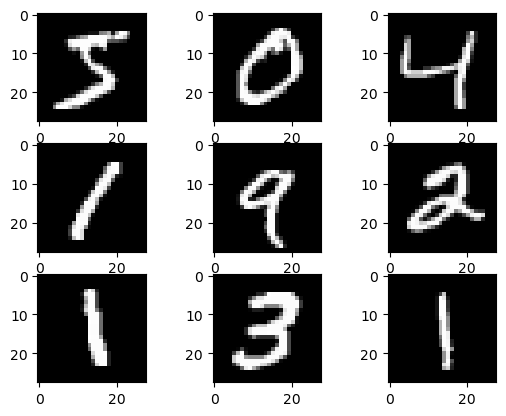

In [164]:
#Visualize the input data

for i in range(len(set(Y_train))-1):
    
 # define subplot w/ 3x3 grid and ith position
 plt.subplot(3, 3, 1+i)
 # plot raw pixel data
 plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

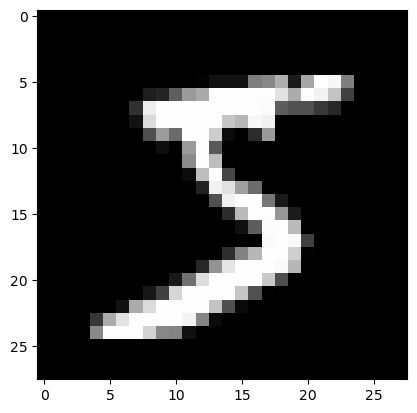

In [165]:
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))

Our training dataset is **60,000** image samples with each of 28x28 pixels represented as a value between 0(black) and 255(white). 

In deep learning and machine learning, it is a common practice to represent image data in a specific format:

Data Shape: Images are typically represented as multi-dimensional arrays (tensors) where each dimension corresponds to a specific aspect of the data. In the case of 2D images, you often have a 3D tensor with dimensions representing (number of samples, height, width).

Channels: Color images usually have three channels **(RGB)**, while grayscale images have a single channel. The number of channels is often the last dimension in the tensor.

In [170]:
# confirm each of the 784 pixel in 28x28 dimension is represented

c = 0

idx = random.randint(0, X_train.shape[0])

for i in X_train[idx]:
    
    for e in i:
        
        c += 1
        
print(c)       

784


In [173]:
# Reshape from 3D to 2D
print(f"Original X_train shape in 3D {X_train.shape}")
X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
X_val = X_val.reshape(X_val.shape[0], -1) / 255.0
X_test = X_test.reshape(X_test.shape[0], -1) / 255.0
print(f"Modified X_train shape in 2D {X_train.shape}")

Original X_train shape in 3D (50000, 28, 28)
Modified X_train shape in 2D (50000, 784)


### Implement from scratch

This neural network has an input layer, a hidden layer, and an output layer. Here's a breakdown of each part of the class and its functionality:

Initialization (Constructor):

The constructor __init__ initializes the neural network. It takes several parameters:

**input_size:** The number of input features.
**hidden_size:** The number of units in the hidden layer.
**output_size:** The number of output units.
**learning_rate:** The learning rate used for gradient descent (default is 0.01)

It initializes the following attributes:

input_size, hidden_size, output_size, and learning_rate.
Weight matrices W1 and W2 for the connections between layers.
Bias vectors b1 and b2 for each layer.
The weights are initialized with random values, and biases are initialized to zeros.

**Activation Functions:**

**_sigmoid:** A method for the sigmoid activation function used in the hidden layer.
**_softmax:** A method for the softmax activation function used in the output layer.

Forward Pass:

**_forward_pass:** This method computes the forward pass of the neural network. Given the input X, it computes the activations and probabilities at the hidden and output layers.
It calculates z1, a1, and z2 using the weight matrices and biases.
The sigmoid activation function is applied to z1, and the softmax activation function to z2.
Loss Function:

**_compute_loss:** A method for calculating the loss based on predicted probabilities (probs) and actual labels (Y). The loss is computed using the cross-entropy loss function.
Backpropagation:

**_backward_pass:** This method performs backpropagation to compute gradients of the loss with respect to the network's parameters.
It calculates delta3, dW2, and db2 for the output layer.
Then, it calculates delta2, dW1, and db1 for the hidden layer.

**Training:**

train: This method trains the neural network using stochastic gradient descent. It takes the input data X and labels Y, along with hyperparameters num_epochs and batch_size.
It iterates through the data for the specified number of epochs.
For each epoch, it processes the data in mini-batches (with size batch_size).
In each mini-batch, it performs a forward pass, computes the loss, and then performs backpropagation to update the weights and biases.
Evaluation:

evaluate: This method evaluates the neural network on a given input X and corresponding labels Y.
It uses the forward pass to make predictions, and then calculates the accuracy by comparing the predicted class labels with the true labels.
Overall, this class encapsulates the entire training and evaluation process of a simple feedforward neural network. You can create an instance of this class, train it on your data, and then evaluate its performance.

In [174]:
class SimpleNeuralNetwork:
    
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        # Initialize weights and biases
        np.random.seed(0)
        self.W1 = np.random.randn(input_size, hidden_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size)
        self.b2 = np.zeros((1, output_size))

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def _softmax(self, x):
        exp_scores = np.exp(x)
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def _forward_pass(self, X):
        z1 = X.dot(self.W1) + self.b1
        a1 = self._sigmoid(z1)
        z2 = a1.dot(self.W2) + self.b2
        return a1, self._softmax(z2)

    def _compute_loss(self, probs, Y):
        corect_logprobs = -np.log(probs[range(Y.shape[0]), np.argmax(Y, axis=1)])
        return np.sum(corect_logprobs) / Y.shape[0]

    def _backward_pass(self, X, Y, a1, probs):
        delta3 = probs
        delta3[range(Y.shape[0]), np.argmax(Y, axis=1)] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(self.W2.T) * (a1 * (1 - a1))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        return dW1, db1, dW2, db2

    def train(self, X, Y, num_epochs=10, batch_size=64):
        for epoch in range(num_epochs):
            for i in range(0, X.shape[0], batch_size):
                X_batch = X[i:i + batch_size]
                Y_batch = Y[i:i + batch_size]

                # Forward pass
                a1, probs = self._forward_pass(X_batch)

                # Compute loss
                loss = self._compute_loss(probs, Y_batch)

                # Backpropagation
                dW1, db1, dW2, db2 = self._backward_pass(X_batch, Y_batch, a1, probs)

                # Update weights and biases
                self.W1 -= self.learning_rate * dW1
                self.b1 -= self.learning_rate * db1
                self.W2 -= self.learning_rate * dW2
                self.b2 -= self.learning_rate * db2

            # Print the loss for this epoch
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss}")

    def evaluate(self, X, Y):
        _, probs = self._forward_pass(X)
        predicted_class = np.argmax(probs, axis=1)
        accuracy = np.mean(predicted_class == np.argmax(Y, axis=1))
        return accuracy

In [175]:
num_classes = 10
Y_train = np.eye(num_classes)[Y_train]
Y_val = np.eye(num_classes)[Y_val]
Y_test = np.eye(num_classes)[Y_test]

model = SimpleNeuralNetwork(input_size=X_train.shape[1], hidden_size=128, output_size=num_classes)
model.train(X_train, Y_train, num_epochs=10, batch_size=64)

val_accuracy = model.evaluate(X_val, Y_val)
print(f"Validation Accuracy: {val_accuracy}")

Epoch 1/10, Loss: 0.8231784867427754
Epoch 2/10, Loss: 0.5634088859862443
Epoch 3/10, Loss: 0.4069516138788648
Epoch 4/10, Loss: 0.3115415727773541
Epoch 5/10, Loss: 0.24290179473165122
Epoch 6/10, Loss: 0.19808658937362306
Epoch 7/10, Loss: 0.1695090272813785
Epoch 8/10, Loss: 0.14760133990934288
Epoch 9/10, Loss: 0.12544012601628937
Epoch 10/10, Loss: 0.10395063686095628
Validation Accuracy: 0.945


In [188]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=2)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

313/313 - 0s - loss: 0.0664 - accuracy: 0.9803 - 408ms/epoch - 1ms/step
Test accuracy: 98.03%


### Implement using Tensorflow

In [182]:
# Load the MNIST dataset
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

# Normalize pixel values to be between 0 and 1
X_train, X_test = X_train / 255.0, X_test / 255.0

In [183]:
# Create a simple feedforward neural network
model = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),  # Flatten the 28x28 input images
    layers.Dense(128, activation='relu'),  # Hidden layer with 128 units and ReLU activation
    layers.Dropout(0.2),  # Dropout layer to prevent overfitting
    layers.Dense(10, activation='softmax')  # Output layer with 10 units for digit classification
])

2023-10-17 01:50:28.568410: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-17 01:50:29.084865: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-17 01:50:29.085096: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [184]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test))

Epoch 1/10


2023-10-17 01:51:10.863821: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc3c90fbad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-17 01:51:10.863852: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-10-17 01:51:10.922489: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-17 01:51:11.432076: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-17 01:51:11.595248: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 [==============================] - 10s 2ms/step - loss: 0.2964 - accuracy: 0.9152 - val_loss: 0.1423 - val_accuracy: 0.9565
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1430 - accuracy: 0.9570 - val_loss: 0.0966 - val_accuracy: 0.9699
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1060 - accuracy: 0.9670 - val_loss: 0.0916 - val_accuracy: 0.9713
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0867 - accuracy: 0.9736 - val_loss: 0.0784 - val_accuracy: 0.9783
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0750 - accuracy: 0.9761 - val_loss: 0.0729 - val_accuracy: 0.9785
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0642 - accuracy: 0.9804 - val_loss: 0.0670 - val_accuracy: 0.9796
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0582 - accuracy: 0.9815 - val_loss: 0.0733 - val_accuracy: 0.9777
Ep

In [185]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=2)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

313/313 - 0s - loss: 0.0664 - accuracy: 0.9803 - 408ms/epoch - 1ms/step
Test accuracy: 98.03%


Text(0.5, 1.0, 'Training and Validation Accuracy')

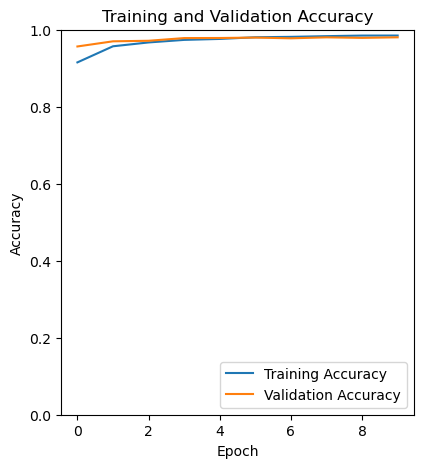

In [186]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

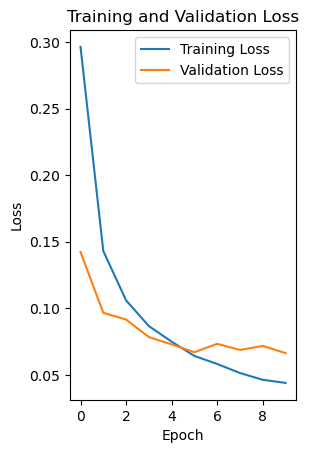

In [187]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()